# Quiz 5

BEFORE YOU START THIS QUIZ:

1. Click on "Copy to Drive" to make a copy of the quiz

2. Click on "Share",
    
3. Click on "Change" and select "Anyone with this link can edit"
    
4. Click "Copy link" and

5. Paste the link into [this Canvas assignment](https://canvas.olin.edu/courses/315/assignments/5149).

Copyright 2021 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [175]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/utils.py')


In [176]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

from utils import decorate

## The Constitution of Knowledge

This question is inspired by Jonathan Rauch's book *The Constitution of Knowledge*, which talks about ways science works as a social enterprise.
Reading it, I thought of an agent-based model we could use to study the dynamics of knowledge creation and dissemination.

In the model, an agent represents a scientist with a belief about whether a hypothesis is true.
Beliefs are represented in the form of probabilities, so one scientist might say there is a 25% chance the hypothesis is true; another might say there is a 75% chance.

In my implementation, these probabilities are stored and computed using
log-odds rather than probabilities.
Log-odds and probabilities are equivalent in the sense that if you are given either, you can compute the other.
To convert from log-odds to probabilities, we can use the `expit` function.

As an example, suppose there are five people with different beliefs, like this:

In [177]:
beliefs = [-2, -1, 0, 1, 2]

We can convert their beliefs to probabilities like this:

In [178]:
from scipy.special import expit

probs = expit(beliefs)
probs

array([0.11920292, 0.26894142, 0.5       , 0.73105858, 0.88079708])

On the log-odds scale, the value `-2` corresponds to a probability around 12%, which represents the belief that the hypothesis is probably false.
The value `2` corresponds to probability 88%, which is probably true.

The log-odds scale makes it easy to update beliefs in light of new evidence.
For example, suppose someone does an experiment that provides evidence in favor of the hypothesis with a log-odds ratio of `0.5`.

In light of this evidence, the scientists can update their beliefs by adding `0.5` to their prior beliefs.

In [179]:
new_beliefs = np.array(beliefs) + 0.5
new_beliefs

array([-1.5, -0.5,  0.5,  1.5,  2.5])

Again, we can use `expit` to compute the corresponding probabilities.

In [180]:
new_probs = expit(new_beliefs)
new_probs

array([0.18242552, 0.37754067, 0.62245933, 0.81757448, 0.92414182])

Having seen the new evidence, all of the the scientists are more confident that the hypothesis is true (although some still believe it is likely to be false).

## Agents

I'll use the following class to represent the scientists.
Each scientist starts with a baseline belief, which is a random value from a normal distribution with mean `0` and standard deviation `1`.

In addition, each scientist has a dictionary of evidence where each item is

* An integer that uniquely identifies a piece of evidence, which maps to

* A floating-point number that quantifies the strength of the evidence as a log-odds ratio.

In [181]:
class Agent:
    def __init__(self):
        self.baseline = np.random.normal(0, 1)
        self.evidence = dict()
        
    def belief(self):
        return self.baseline + sum(self.evidence.values())
    
    def update(self, evidence):
        self.evidence.update(evidence)

The `belief` method computes the agent's degree of belief in a hypothesis, which is the sum of their baseline belief and the total of all evidence they have seen.

The `update` method updates an agent's belief by adding entries to their `evidence` dictionary.
Because the keys in a dictionary are unique, a scientist who sees the same evidence twice will only add it to their dictionary once.

To show how this works, I'll make 100 agents with random baseline beliefs:

In [182]:
agents = [Agent() for i in range(100)]

We can extract their total beliefs like this:

In [183]:
beliefs = [agent.belief() for agent in agents]

Because the agents haven't seen any evidence yet, the distribution of belief is normal with mean `0` and standard deviation `1`.

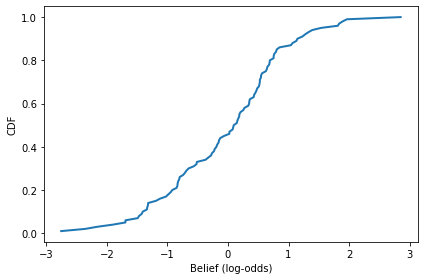

In [184]:
from empiricaldist import Cdf

cdf = Cdf.from_seq(beliefs)
cdf.plot()
decorate(xlabel='Belief (log-odds)',
         ylabel='CDF')

We can convert the beliefs to probabilities like this:

In [185]:
probs = expit(beliefs)

And here's what the distribution looks like.

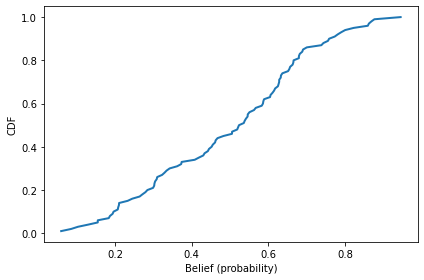

In [186]:
cdf = Cdf.from_seq(probs)
cdf.plot()
decorate(xlabel='Belief (probability)',
         ylabel='CDF')

The mean of this distribution is initially near 50%.

In [187]:
probs.mean()

0.4973612260330125

## Experiment 1

Now let's see what happens if the scientists run experiments and gather evidence.

The following function simulates a world where the hypothesis is true and every experiment yields evidence in favor of the hypothesis, with a log-odds ratio of `0.1` (which is one decibel).

During each time step, one randomly-chosen agent does an experiment and uses the result to update their belief.  

In [188]:
def run_simulation1(agents):
    for key in range(100):
        value = 0.1
        agent = np.random.choice(agents)
        agent.update({key: value})

I'll use the following function to plot the distribution of probabilities before and after the simulation.

In [189]:
def plot_prob_dist(agents):
    beliefs = [agent.belief() for agent in agents]
    probs = expit(beliefs)
    Cdf.from_seq(probs).plot()
    decorate(xlabel='Belief (probability)',
             ylabel='CDF')
    return np.mean(beliefs)

Here's what the results look like:

(0.11311698698788844, 0.21311698698788842)

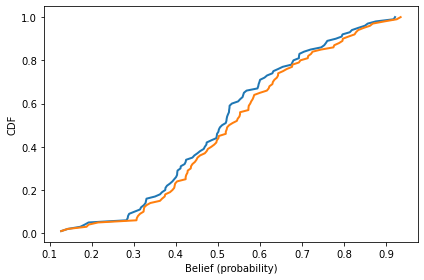

In [190]:
num_steps = 100
agents = [Agent() for i in range(num_steps)]

mean_before = plot_prob_dist(agents)
run_simulation1(agents)
mean_after = plot_prob_dist(agents)

mean_before, mean_after

As you might expect, the experimental results shift the distributions to the right and increase the "center of mass", represented by the mean belief in log-odds.

In this simulation, the scientists don't share information, so beliefs don't change very fast.

In [191]:
velocity = (mean_after - mean_before) / num_steps
velocity

0.0009999999999999998

The average change in belief is only 0.001 bels per time step.

## Experiment 2

The previous experiment simulates a world where scientists work in isolation and do not share the evidence they discover with anyone.
At the opposite extreme, suppose everyone broadcasts the results of their experiments and everyone else updates their beliefs accordingly.

The following function simulates this behavior.

In [193]:
def run_simulation2(agents):
    for key in range(100):
        value = 0.1
        for agent in agents:
            agent.update({key: value})

Here's what the results look like.

(-0.0675429522228491, 9.932457047777133)

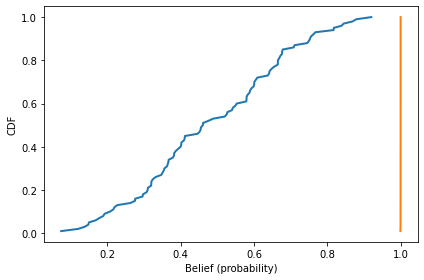

In [194]:
num_steps = 100
agents = [Agent() for i in range(num_steps)]

mean_before = plot_prob_dist(agents)
run_simulation2(agents)
mean_after = plot_prob_dist(agents)

mean_before, mean_after

In this utopia of scientific discourse, even the most skeptical scientist is quickly convinced that the hypothesis is likely to be true.

In [195]:
velocity = (mean_after - mean_before) / num_steps
velocity

0.09999999999999983

And the average velocity is 0.1 bels per timestep, which is the rate at which new evidence enters the system.

## Experiment 3

Of course, there are many ways the real world does not live up to this ideal.

* For example, not every experiment is perfect; due to error and randomness, we expect variation in the strength of evidence and some possibility of finding evidence against the hypothesis, even if it is true.

* The ways we have for sharing evidence are not perfect; not every scientist reads every paper.

* And scientists themselves are not perfect; they are subject to the same biases and systematic errors as any other human.

To get us started, I will explore the effect of the first phenomenon, imperfect experiments, and you will have a chance to explore one or more of the others.

The following function simulates a world where the evidence we get from an experiment follows a normal distribution with mean 0.1 and standard deviation 0.1 (which means that it is sometimes negative).

As in the previous simulation, all results are broadcast to all scientists.

In [196]:
def run_simulation3(agents, stddev=0.1):
    for key in range(100):
        value = np.random.normal(0.1, stddev)
        for agent in agents:
            agent.update({key: value})

Here's what the results look like.

(-0.12532782114728355, 8.777700972445386)

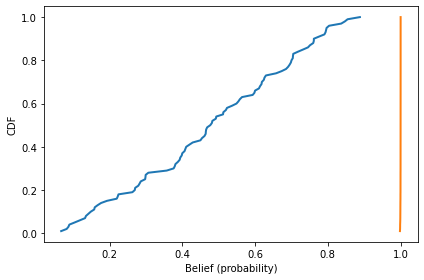

In [197]:
num_steps = 100
agents = [Agent() for i in range(num_steps)]

mean_before = plot_prob_dist(agents)
run_simulation3(agents)
mean_after = plot_prob_dist(agents)

mean_before, mean_after

In this version of the model, average velocity varies from one run to the next, but it is usually close to 0.1 bels per timestep.

In [200]:
velocity = (mean_after - mean_before) / num_steps
velocity

0.0890302879359267

Let's see how it depends on the variability of evidence.

In [201]:
stddev_array = np.linspace(0, 1, 11)
stddev_array

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [202]:
def mean_belief(agents):
    return np.mean([agent.belief() for agent in agents])

In [203]:
num_steps = 100
velocities = []

for stddev in stddev_array:
    mean_before = mean_belief(agents)
    agents = [Agent() for i in range(num_steps)]
    run_simulation3(agents, stddev)
    mean_after = mean_belief(agents)
    velocity = (mean_after - mean_before) / num_steps
    velocities.append(velocity)

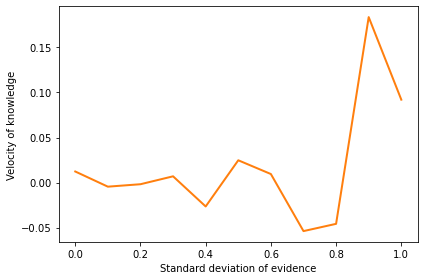

In [204]:
plt.plot(stddev_array, velocities, 'C1')
decorate(xlabel='Standard deviation of evidence',
         ylabel='Velocity of knowledge')

The standard deviation of evidence does not increase or decrease the velocity of knowledge, but it makes progress more variable from one run to the next, with the possibility of going in the wrong direction, at least for a while.

## Experiment 4

Run an experiment that adds a feature to this model and tests its effect on the velocity of knowledge.

* To model imperfections in the dissemination of knowledge, you could arrange the agents in space, or on a network, where they only share knowledge with neighbors.

* To model imperfections in human behavior, you could model a phenomenon like confirmation bias, which is the tendency to accept new evidence only if it is consistent with your current beliefs. Or the possibility of counting the same piece of evidence more than once if you hear it from more than one source.

Whatever feature you add, you should:

1) Explain what behavior or structure in the real world the feature is meant to represent.

2) Explain your implementation, that is, what changes you made in the code to add the feature,

3) Run the experiment and compare the velocity of knowledge with and without the new feature.

If possible, you should also:

4) Define a parameter that quantifies the strength or severity of the new feature (like standard deviation in Experiment 3),

5) Run the experiment with a range of values for that parameter, and

6) Plot the velocity of knowledge as a function of the parameter.

Finally, you should interpret the results in the context of the original question: what does your experiment tell us about the "Constitution of Knowledge"; that is, how does our ability to learn about the world depend on the behavior of scientists and how they share evidence?
